In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.patches as patches

from config import Config
import utils
import model as modellib
import visualize
from model import log

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 


# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_ocr_0002.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "data/image")

Using TensorFlow backend.


In [1]:
import ocr
    
config = ocr.OcrConfig()
config.display()

/home/nghia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        180
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           ocr
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING       

In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
# Training dataset
dataset_train = ocr.OcrDataset()
dataset_train.load_ocr(np.load('ocr-train-cv.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = ocr.OcrDataset()
dataset_val.load_ocr(np.load('ocr-val.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

(55,)
(1024, 1024, 55)


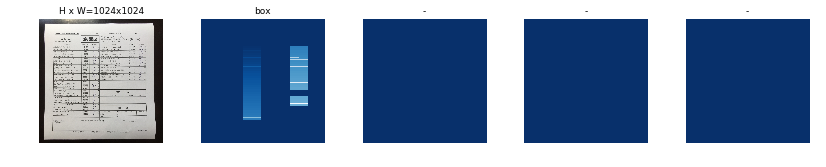

In [6]:
# Load and display random samples
plt.figure(figsize=(10, 10))
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids.shape)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
# class InferenceConfig(ocr.Config()):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()
config.GPU_COUNT =1
config.IMAGES_PER_GPU =1
config.BATCH_SIZE = 1
    
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_ocr_0002.h5")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/nghia/work/Mask_RCNN/logs/ocr20180406T1009/mask_rcnn_ocr_0010.h5


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -115.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(53, 4)
(1024, 1024, 53)
(53,)


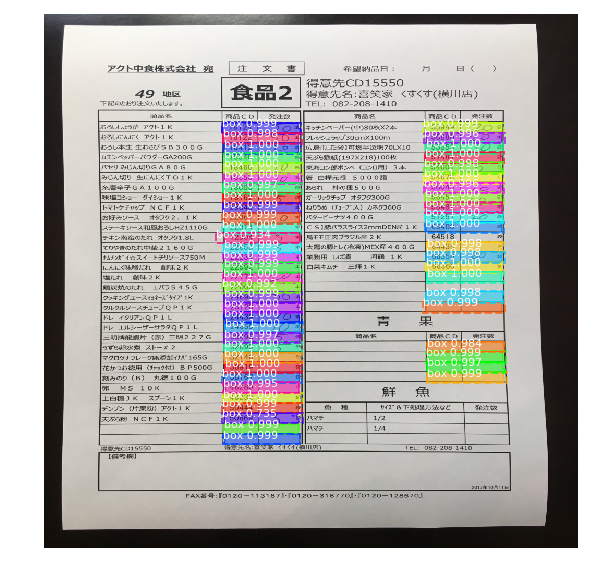

In [11]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 3
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask = False)

results = model.detect([original_image], verbose=1)

r = results[0]
print(r['rois'].shape)
print(r['masks'].shape)
print(r['scores'].shape)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(10, 10))

In [13]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon

print(r['masks'].shape)
print(r['masks'][:,:,0].shape)

masks = r['masks']
classes = r['class_ids']
print(classes.shape)

i = 1
mask = masks[:, :, i]
# masked_image = apply_mask(masked_image, mask, color)

# Mask Polygon
# Pad to ensure proper polygons for masks that touch image edges.
padded_mask = np.zeros(
    (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
padded_mask[1:-1, 1:-1] = mask
contours = find_contours(padded_mask, 0.5)

(1024, 1024, 53)
(1024, 1024)
(53,)


In [14]:
# import the necessary packages
import numpy as np
import cv2

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
#     print("four_point_transform rect", rect)

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [15]:
from skimage.feature import corner_harris, corner_peaks
import matplotlib.patches

def predict_mask(original_image, mask, box):
    y1, x1, y2, x2 = box

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
#     print("box", box)
#     print("original_image", original_image.shape)
#     print("mask", mask.shape)
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
#     print("padded_mask", padded_mask.shape)
#     plt.imshow(padded_mask)
#     plt.show()
    verts1 = corner_peaks(corner_harris(padded_mask), min_distance=1)
#     print("corner_harris", verts1.shape)
#     print(verts1)
#     verts1 = np.append(verts1, [[y1-5, x1-5], [y2+5, x2+5]], axis=0)
#     print(verts1)
#     verts1.stack((np.array(y1, x1), np.array(y2, x2)))
    verts1 = np.fliplr(verts1) - 1
#     print(verts1.shape)
    crop_img = original_image.copy()
    
#     print(boxes[i])
#     crop_img
    crop_img = crop_img[y1-5:y2+5,x1-1:x2+1,:]
#     print("crop_img", crop_img.shape)
#     plt.imshow(crop_img[y1:y2,x1:x2,:])
#     plt.show()
#     plt.figure(figsize=(12, 12))
    image = original_image.copy()
    pts = np.array(verts1, dtype = "float32")
    rect = order_points(pts)
#     print("pts", pts)
#     print("rect", rect)
    (tl, tr, br, bl) = rect
    
    rect[0] = [tl[0]-1, tl[1]-8]
    rect[1] = [tr[0]+1, tr[1]-8]
    rect[2] = [br[0]+1, br[1]+8]
    rect[3] = [bl[0]-1, bl[1]+8]
#     print("rect0", rect[0])
#     print("rect1", rect[1])
#     pts.concatenate([[x1, y1]], [[x2, y2]])

    # apply the four point tranform to obtain a "birds eye view" of
    # the image
    warped = four_point_transform(image, rect)
#     print("warped", warped.shape)
    return crop_img, warped
#     text = pytesseract.image_to_string(warped, config='')

In [91]:
def extract_pred(image_id, original_image, masks, boxes, classes, class_pred=2, save_dir=''):
    crops = []
    wraps = []
    for i in range(masks.shape[2]):
#         print(i)
        mask = masks[:, :, i]
        box = boxes[i]
        class_id = classes[i]
        if class_id == class_pred:
            crop_img, warped = predict_mask(original_image, mask, box)
            crops.append(crop_img)
            wraps.append(warped)
            if False:
                p_crop = os.path.join(save_dir, "%03d_%03d_crop.jpg" % (image_id, i))
                p_wrap = os.path.join(save_dir, "%03d_%03d_wrap.jpg" % (image_id, i))
#                 print(p_crop)
#                 print(p_wrap)
                cv2.imwrite(p_crop, crop_img)
                cv2.imwrite(p_wrap, warped)
            if True:
                print("crop")
                plt.figure(figsize=(12, 12))
                plt.imshow(crop_img)
                plt.show()
                print("wraped")
                plt.figure(figsize=(12, 12))
                plt.imshow(warped)
                plt.show()
    
    return crops, wraps

In [26]:
def predict_and_extract(image_id, dataset_val, save_dir=""):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config, 
                               image_id, use_mini_mask = False)

    results = model.detect([original_image], verbose=1)

    r = results[0]
    print(r['masks'].shape)
    print(r['rois'].shape)
    print(r['class_ids'].shape)
    extract_pred(image_id, original_image, r['masks'], r['rois'],  r['class_ids'], class_pred=1, save_dir=save_dir)
    # visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
    #                             dataset_val.class_names, r['scores'], figsize=(10, 10))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -117.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(1024, 1024, 56)
(56, 4)
(56,)
crop


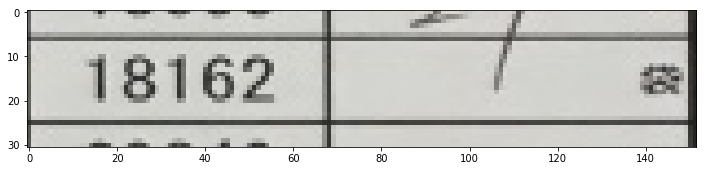

wraped


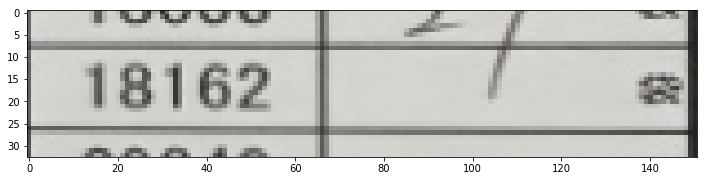

crop


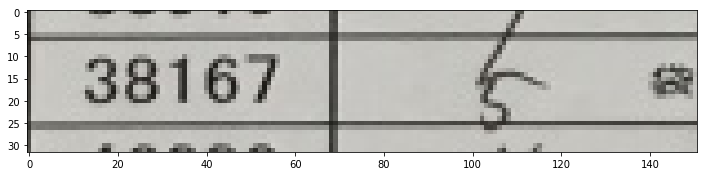

wraped


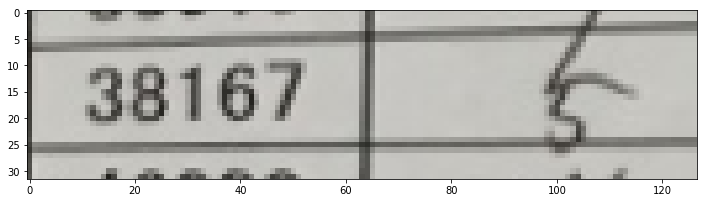

crop


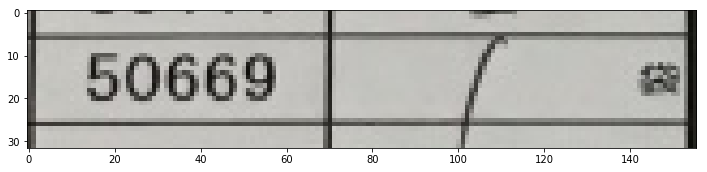

wraped


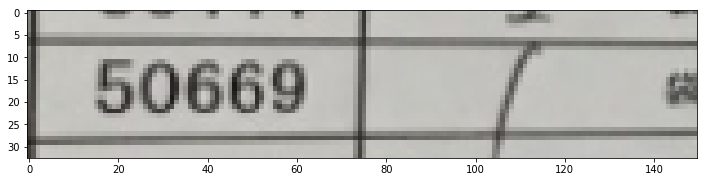

crop


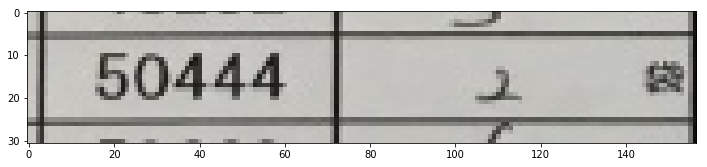

wraped


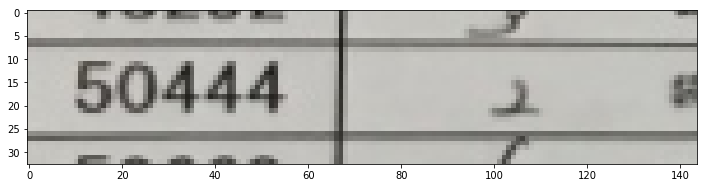

crop


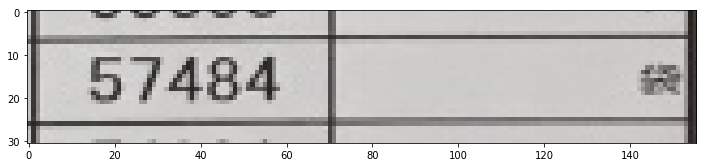

wraped


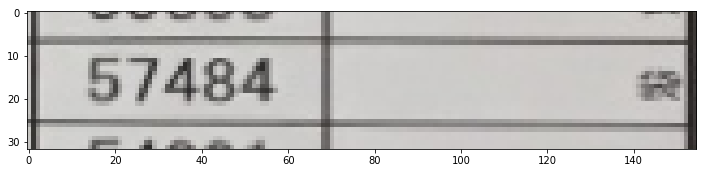

crop


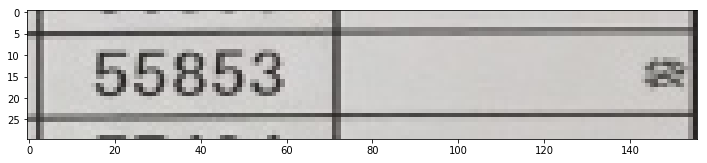

wraped


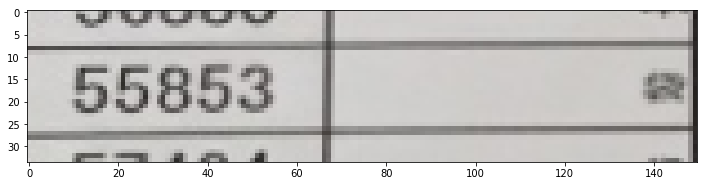

crop


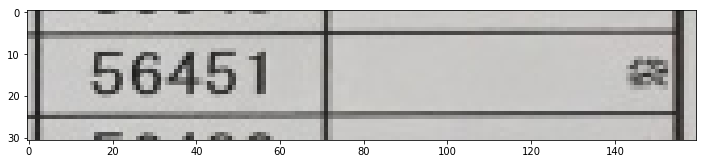

wraped


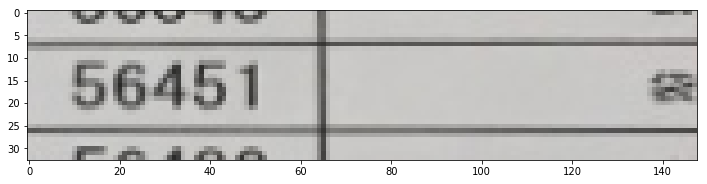

crop


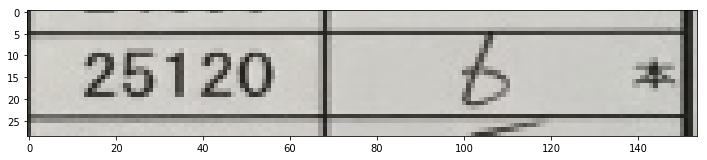

wraped


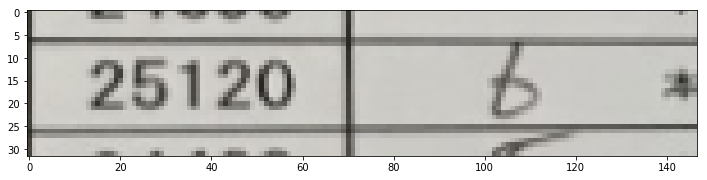

crop


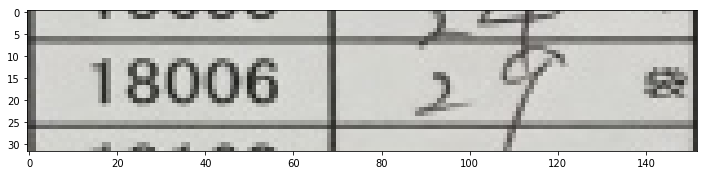

wraped


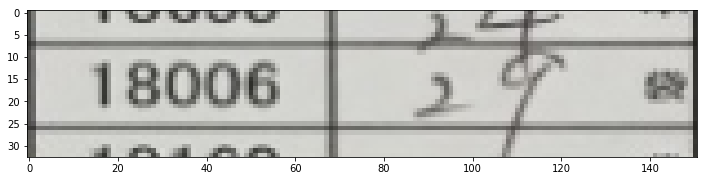

crop


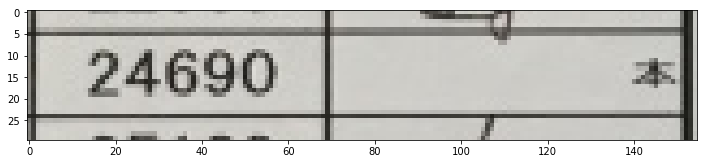

wraped


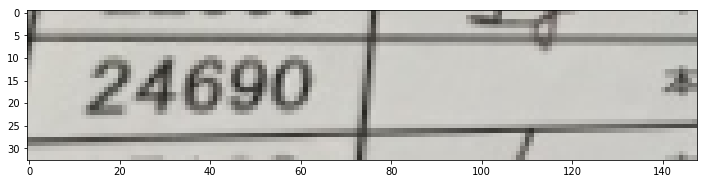

crop


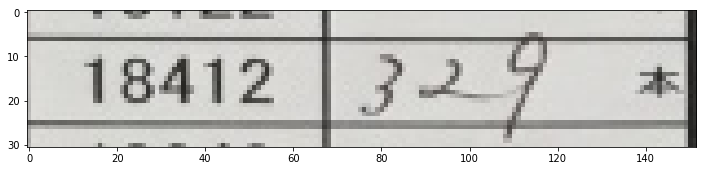

wraped


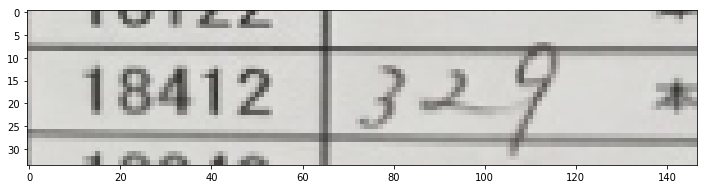

crop


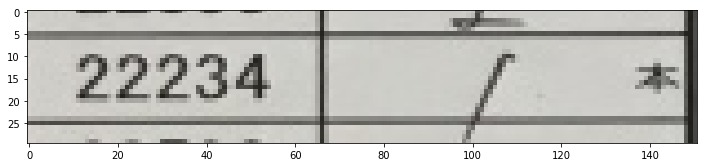

wraped


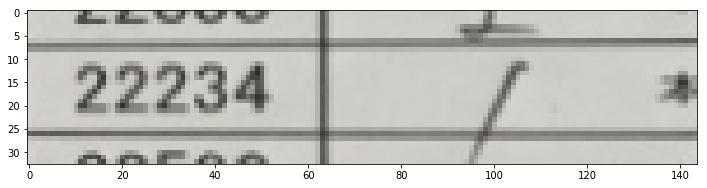

crop


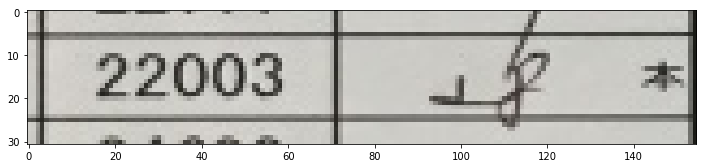

wraped


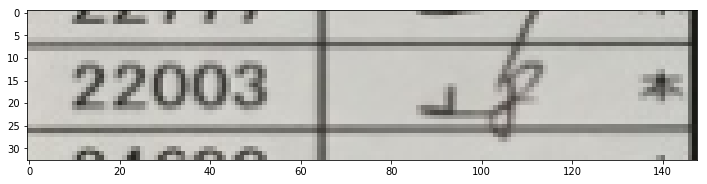

crop


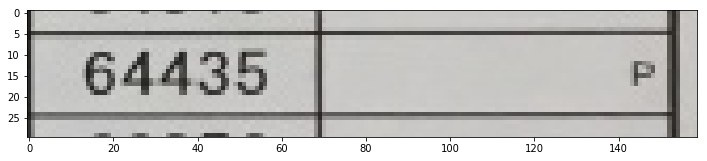

wraped


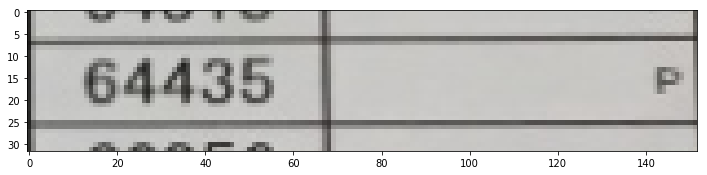

crop


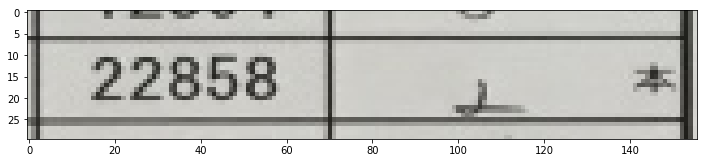

wraped


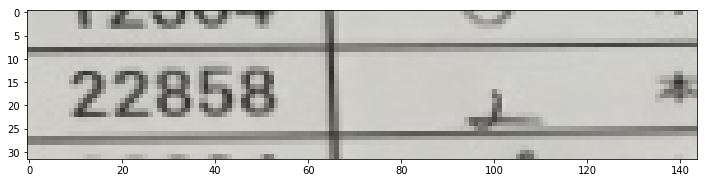

crop


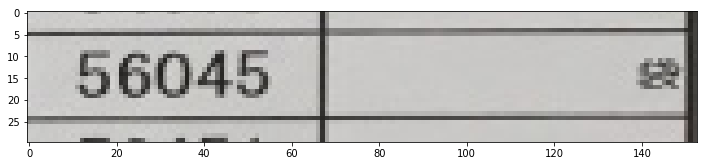

wraped


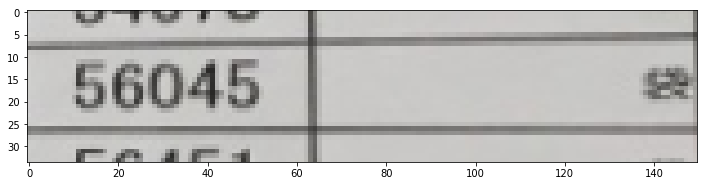

crop


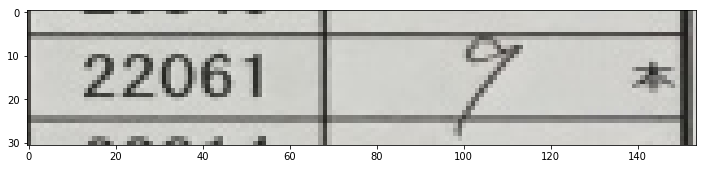

wraped


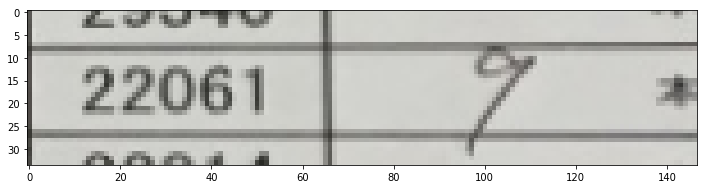

crop


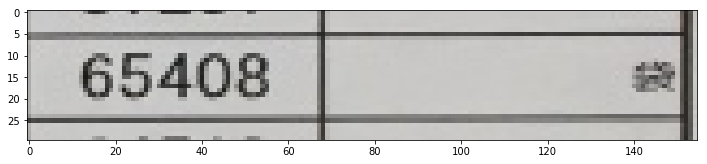

wraped


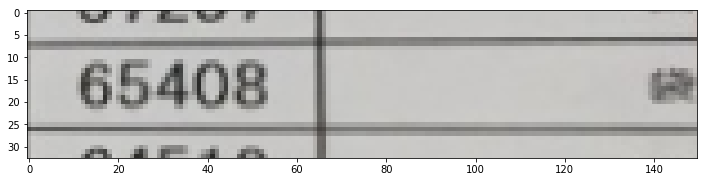

crop


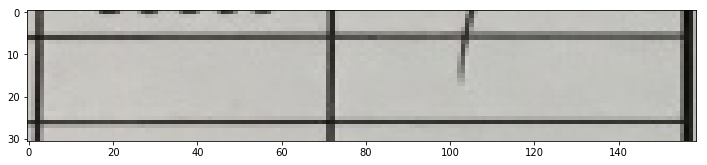

wraped


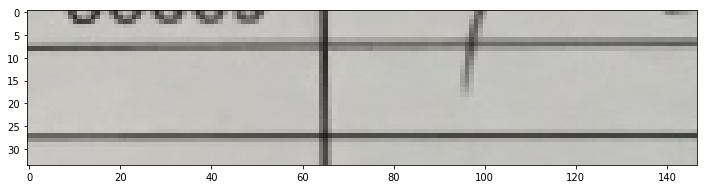

crop


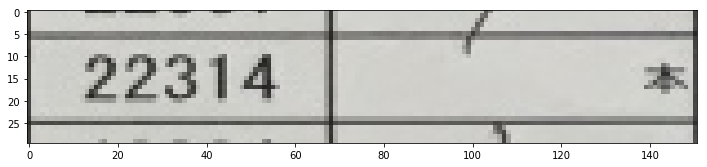

wraped


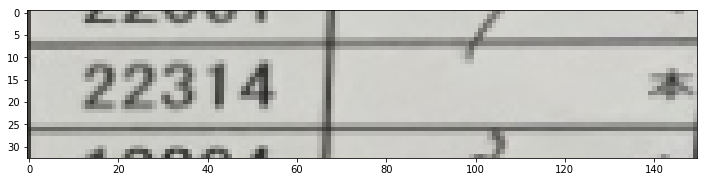

crop


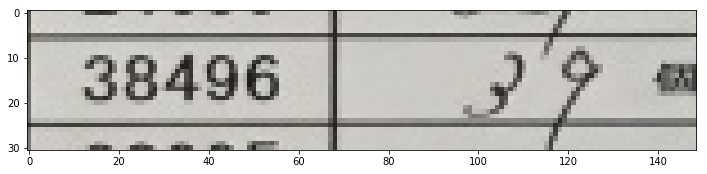

wraped


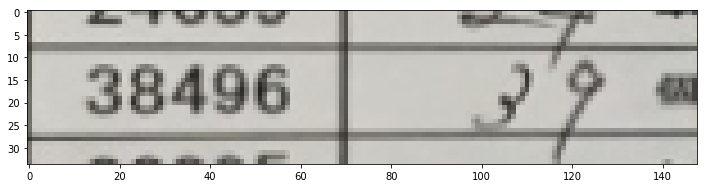

crop


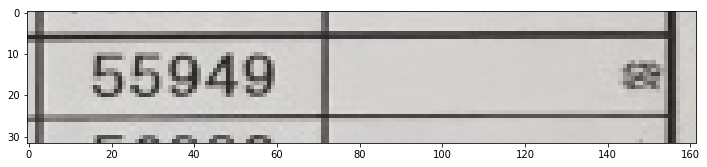

wraped


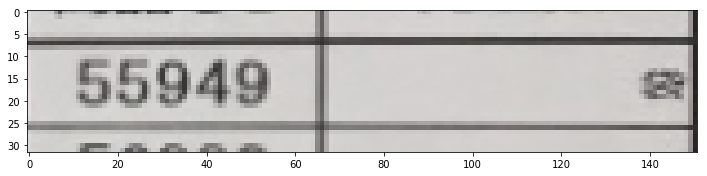

crop


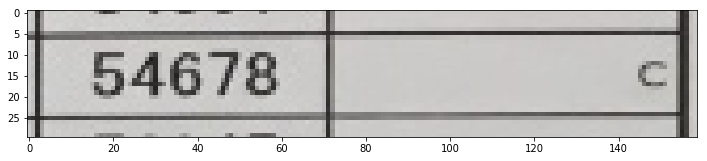

wraped


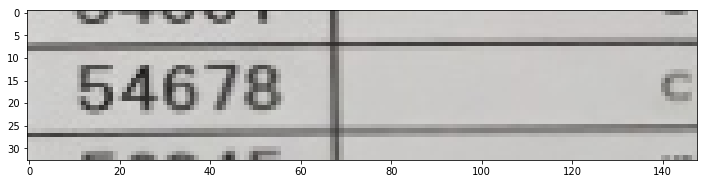

crop


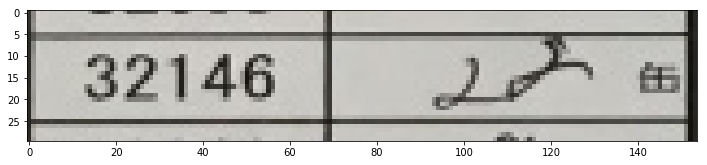

wraped


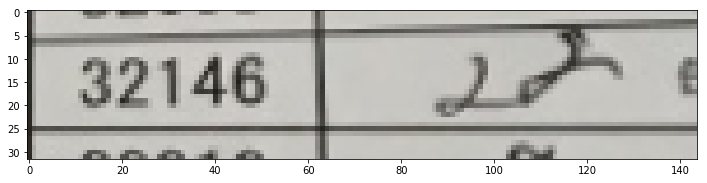

crop


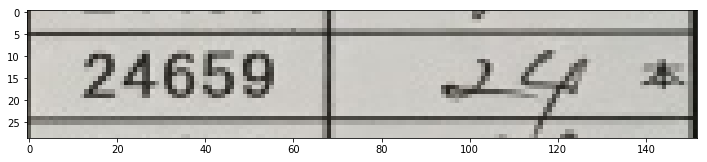

wraped


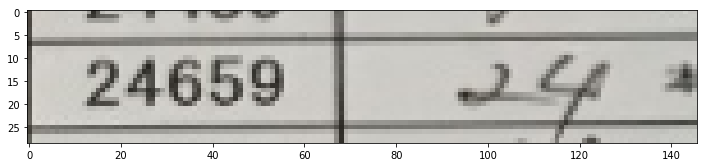

crop


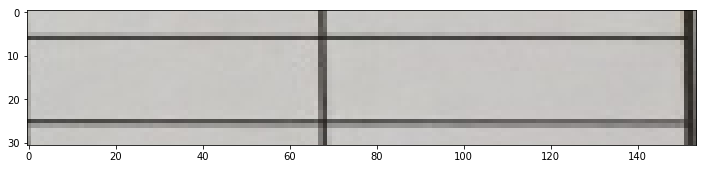

wraped


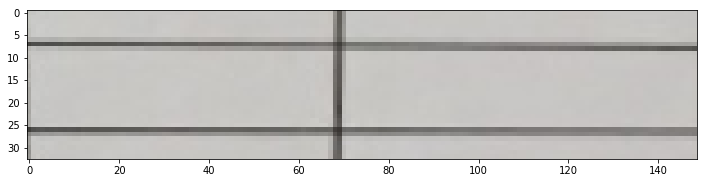

crop


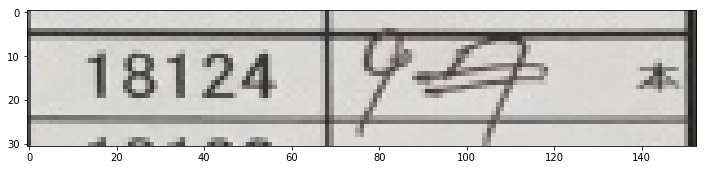

wraped


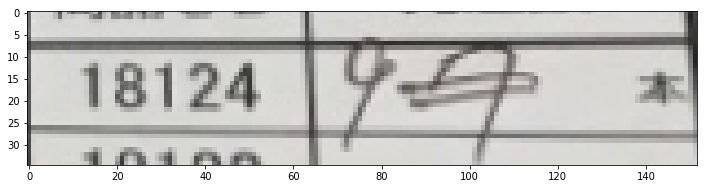

crop


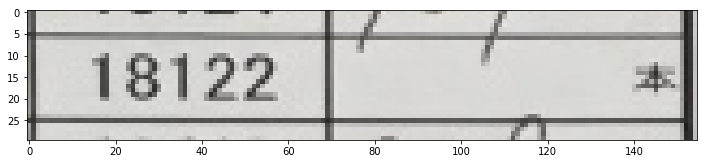

wraped


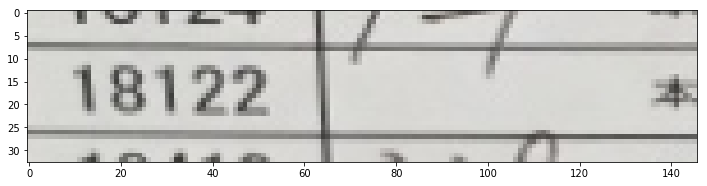

crop


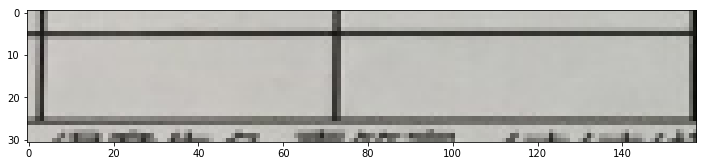

wraped


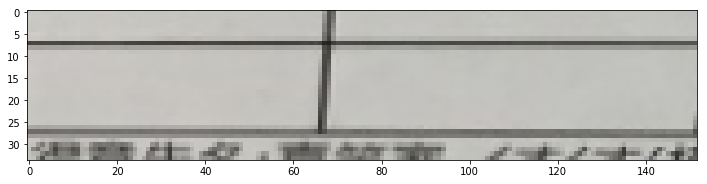

crop


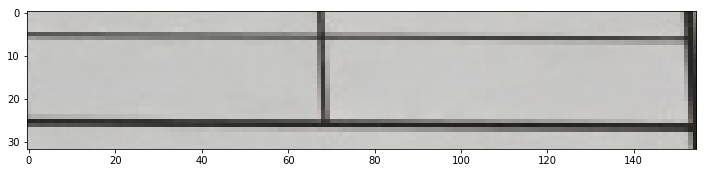

wraped


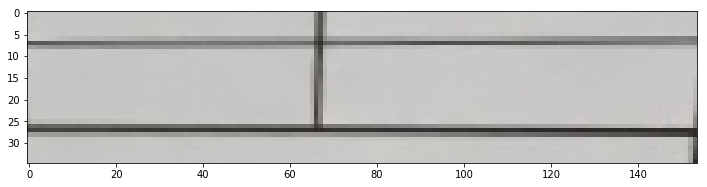

crop


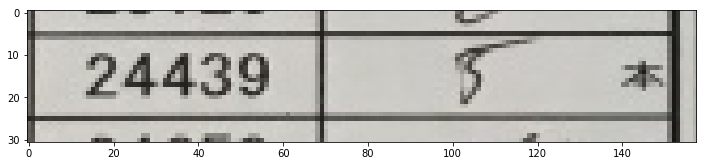

wraped


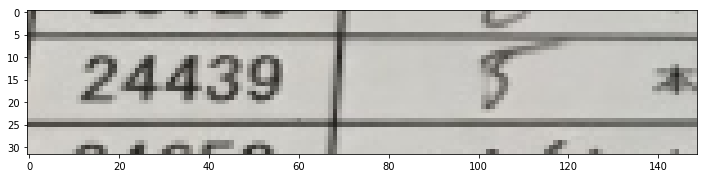

crop


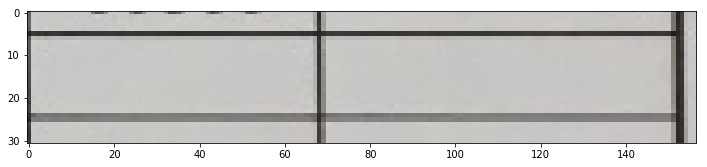

wraped


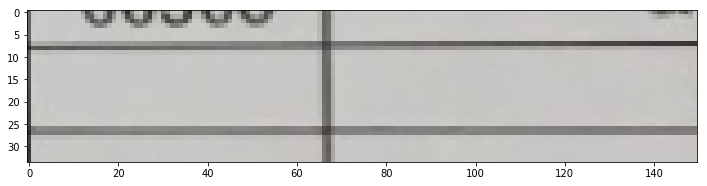

crop


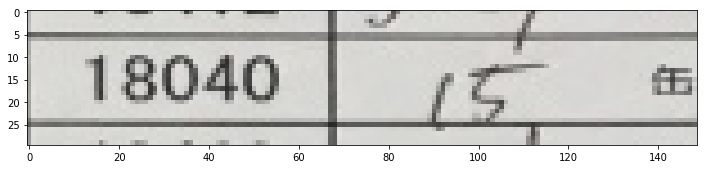

wraped


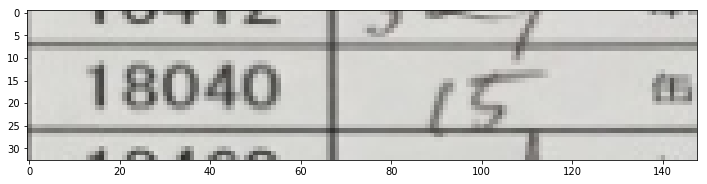

crop


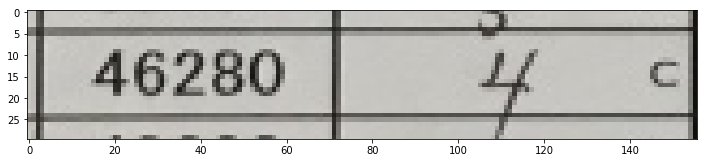

wraped


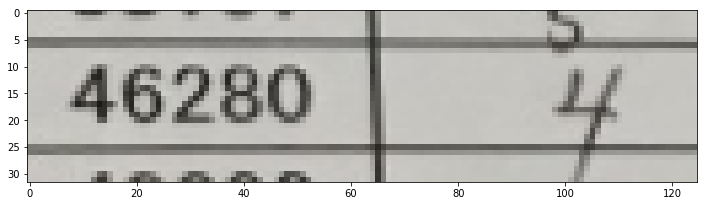

crop


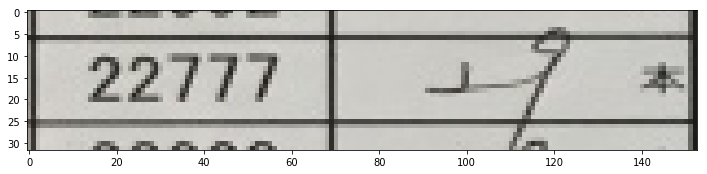

wraped


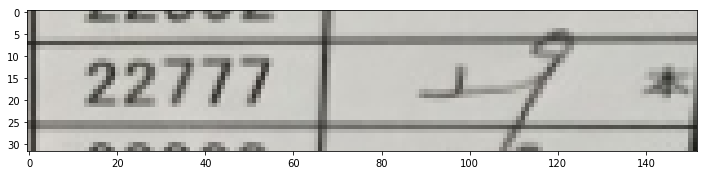

crop


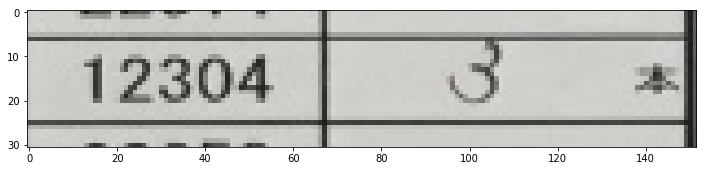

wraped


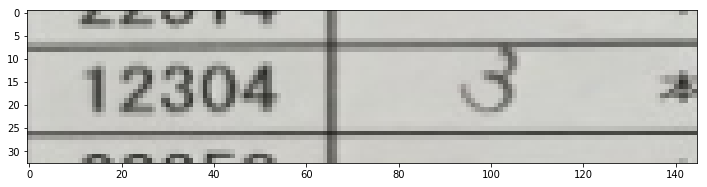

crop


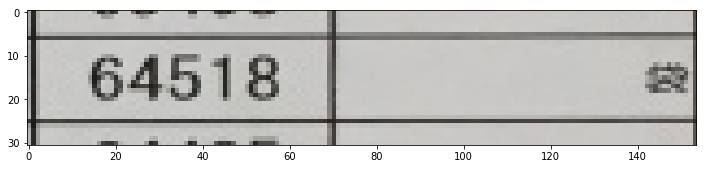

wraped


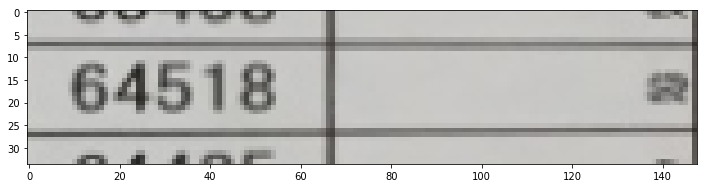

crop


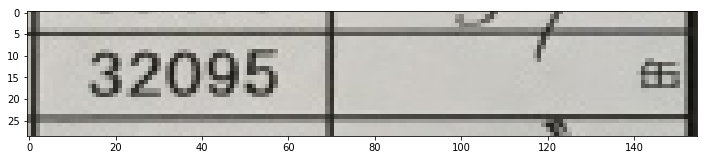

wraped


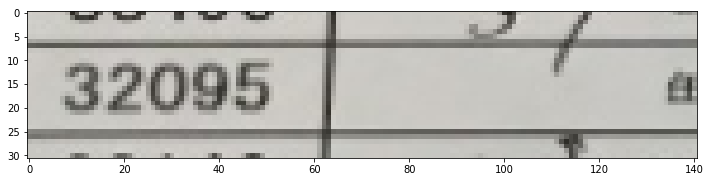

crop


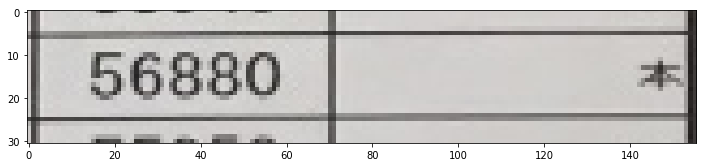

wraped


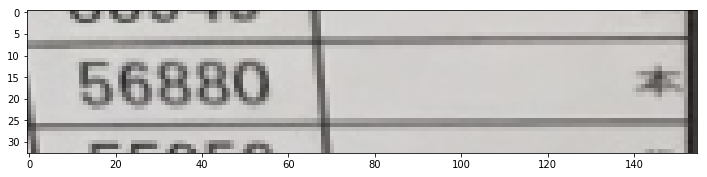

crop


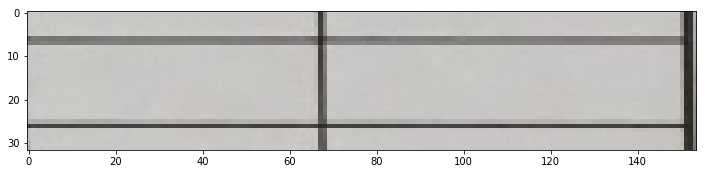

wraped


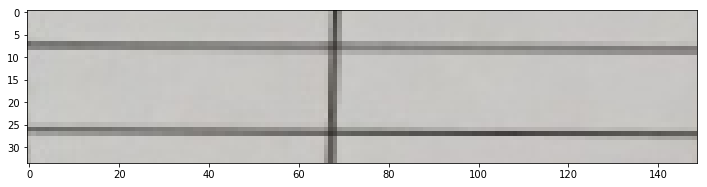

crop


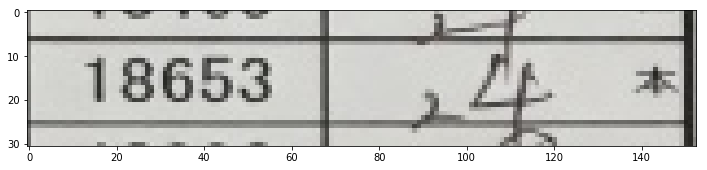

wraped


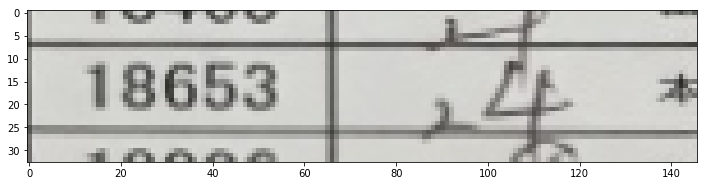

crop


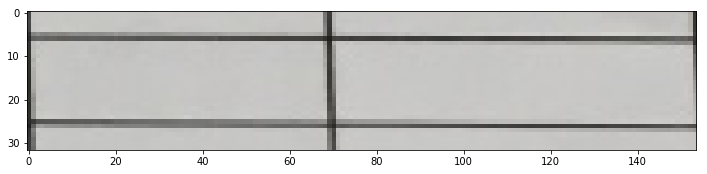

wraped


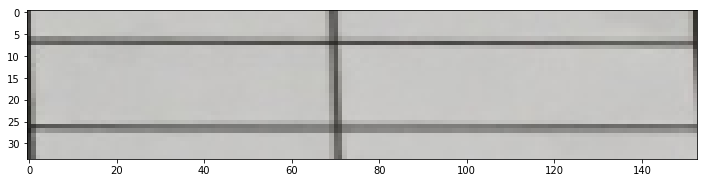

crop


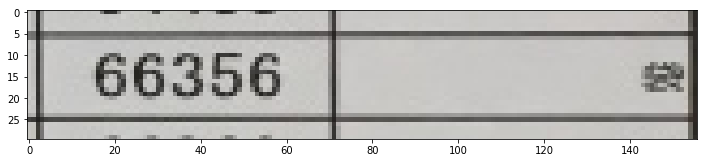

wraped


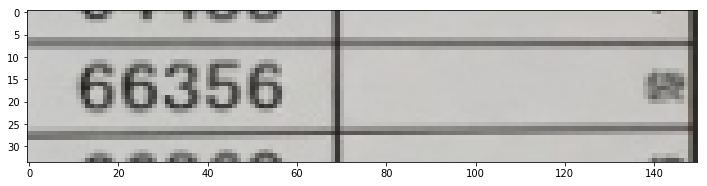

crop


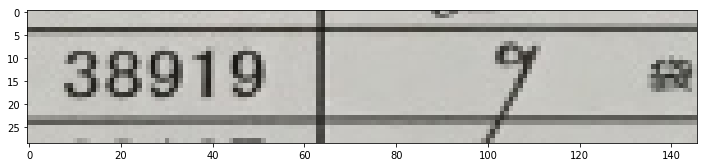

wraped


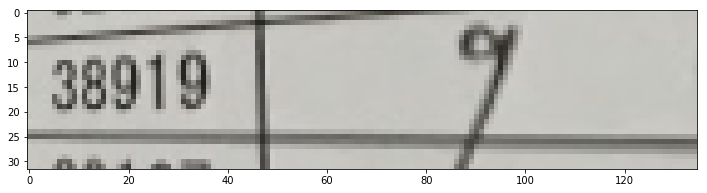

crop


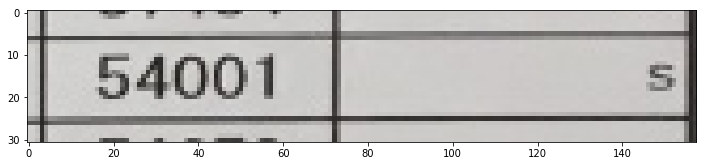

wraped


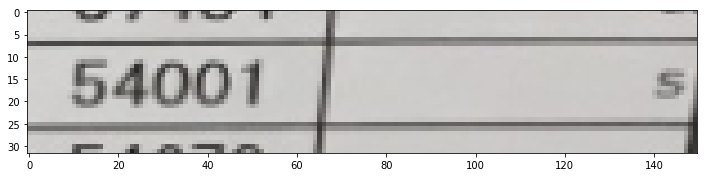

crop


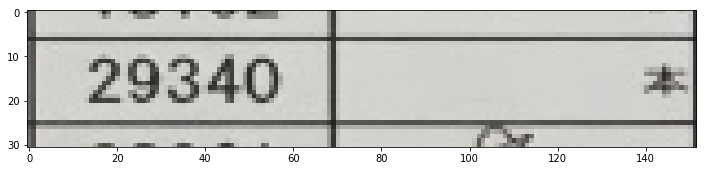

wraped


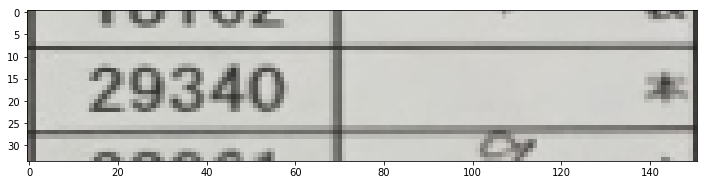

crop


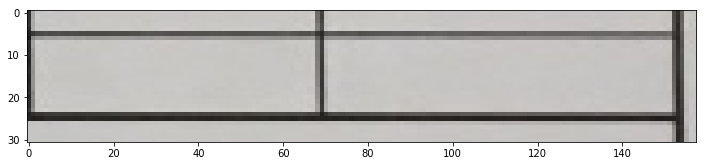

wraped


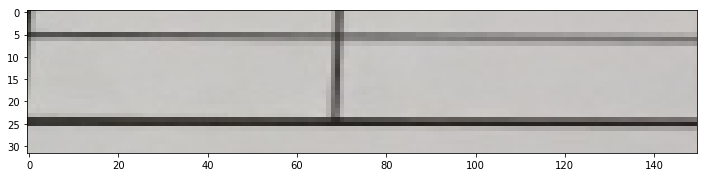

crop


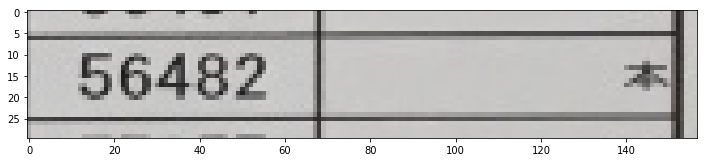

wraped


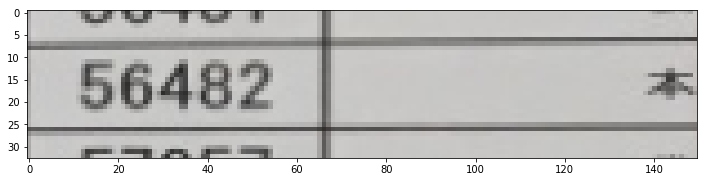

crop


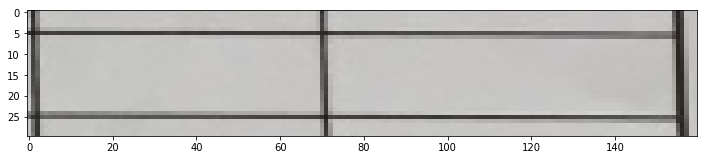

wraped


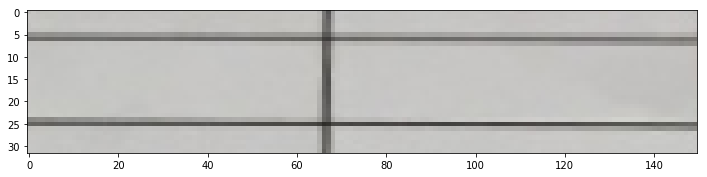

crop


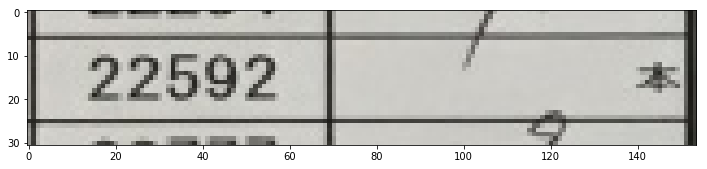

wraped


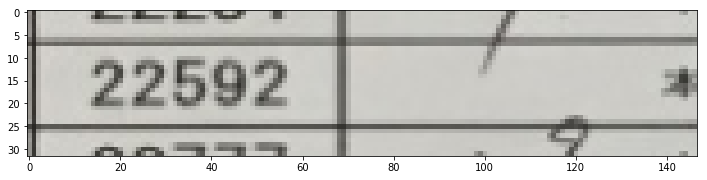

crop


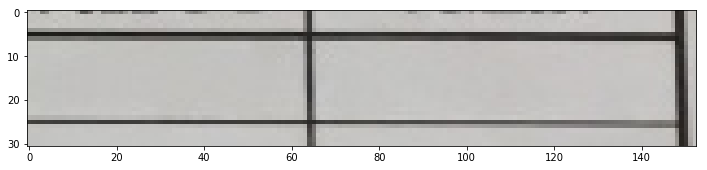

wraped


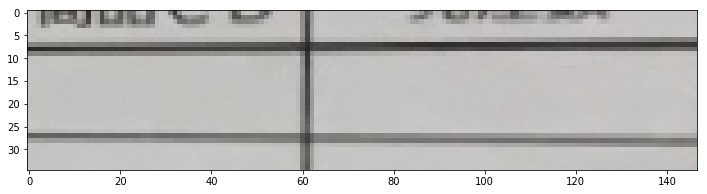

crop


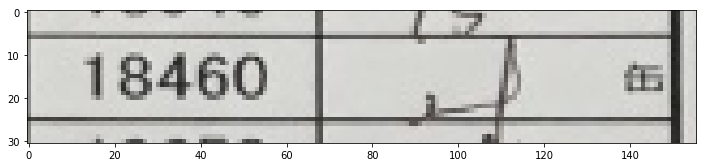

wraped


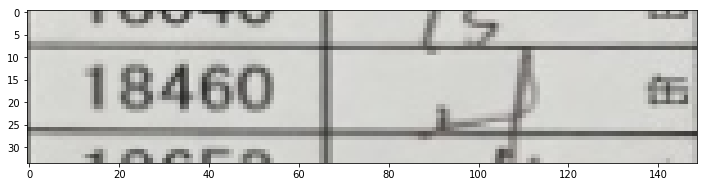

crop


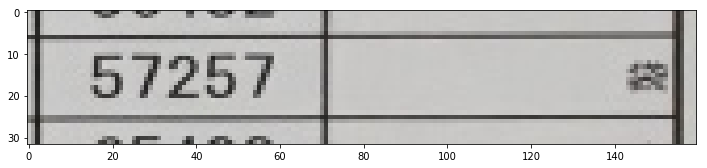

wraped


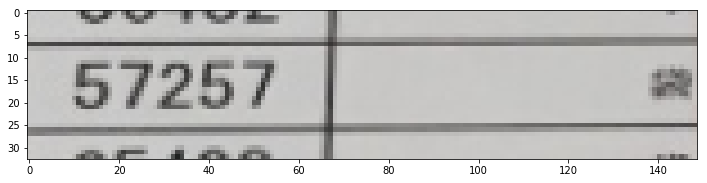

crop


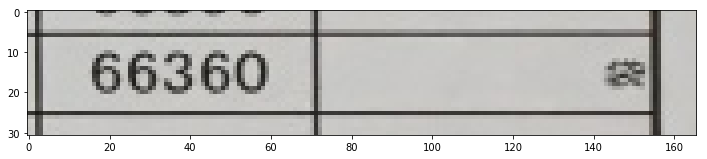

wraped


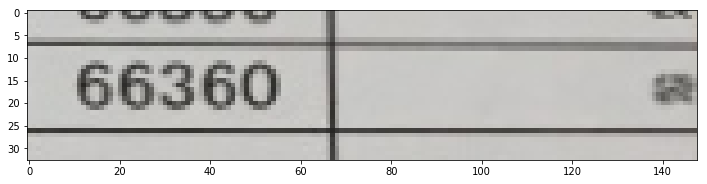

crop


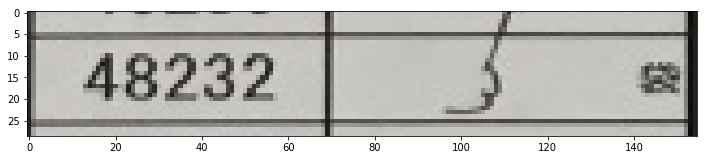

wraped


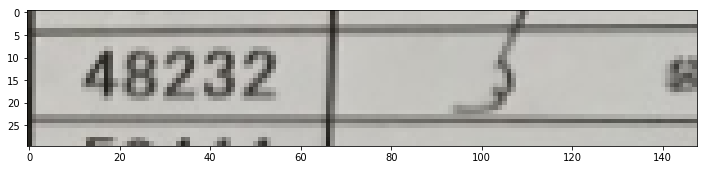

crop


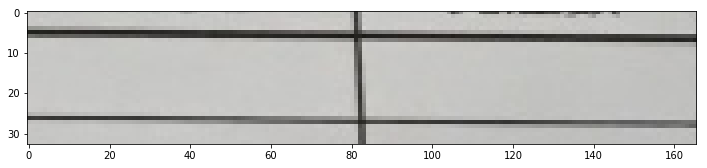

wraped


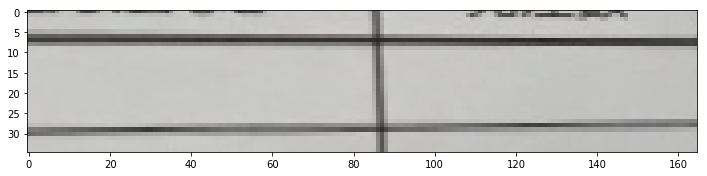

In [27]:
predict_and_extract(1, dataset_val)
# print(dataset_val.image_ids)
# for image_id in dataset_val.image_ids:
#     print(image_id)
#     predict_and_extract(image_id, dataset_val, save_dir="data/handwriting")

In [92]:
import skimage
class_names = ['BG', 'box']
def predict_and_extract1(image_path, i=0, save_dir=""):
    image = skimage.io.imread(image_path)
    results = model.detect([image], verbose=1)

    r = results[0]
    print(r['masks'].shape)
    print(r['rois'].shape)
    print(r['class_ids'].shape)
    print(r['masks'][:,:,i:i+1].shape)
    visualize.display_instances(image, r['rois'][i:i+1,:], r['masks'][:,:,i:i+1], r['class_ids'][i:i+1], 
                            class_names, r['scores'][i:i+1])
    return image, r


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    5.00000  max:  251.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -104.80000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(1024, 1024, 46)
(46, 4)
(46,)
(1024, 1024, 1)
crop


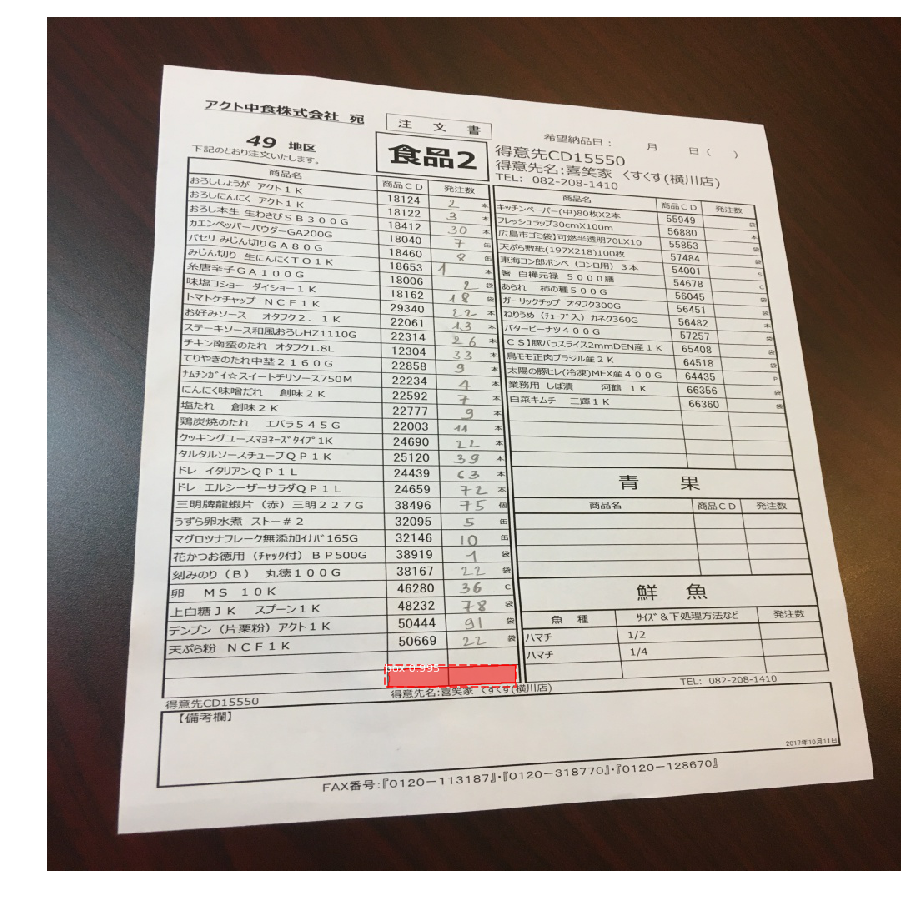

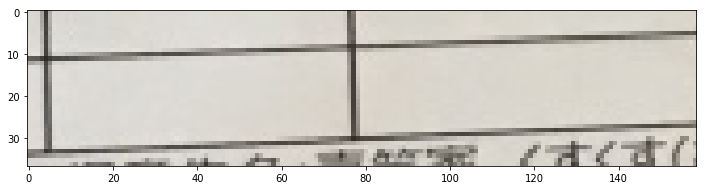

wraped


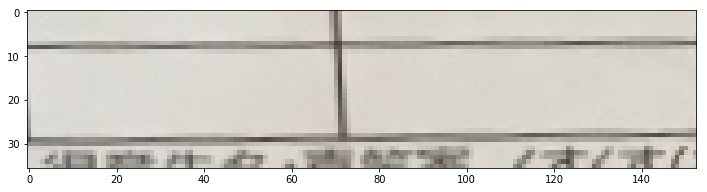

In [93]:
i = 23
image, r = predict_and_extract1("data/image/imageresized_66.jpg", i=i)
crops, wraps = extract_pred(image_id, image, r['masks'][:,:,i:i+1], r['rois'][i:i+1,:],  r['class_ids'][i:i+1], class_pred=1, save_dir="")

crop


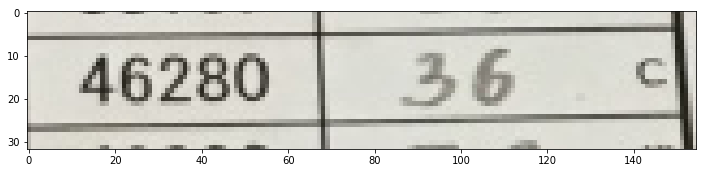

wraped


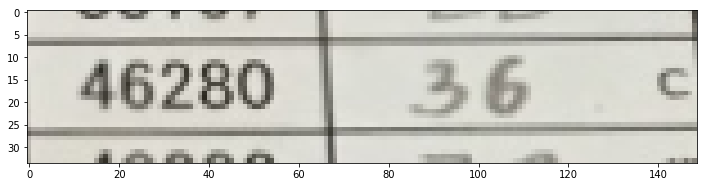

crops (1, 32, 155, 3) wraps (1, 34, 149, 3)


In [114]:
i = 3
crops, wraps = extract_pred(image_id, image, r['masks'][:,:,i:i+1], r['rois'][i:i+1,:],  r['class_ids'][i:i+1], class_pred=1, save_dir="")
print("crops", np.array(crops).shape, "wraps", np.array(wraps).shape)

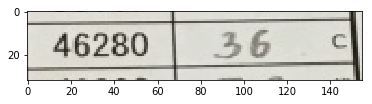

In [115]:
plt.imshow(crops[0])
plt.show()

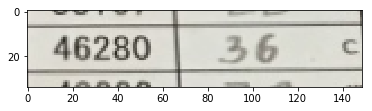

In [116]:
plt.imshow(wraps[0])
plt.show()

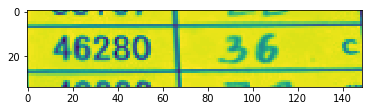

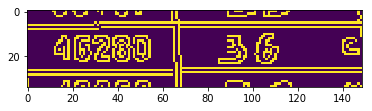

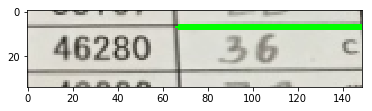

In [132]:
img = wraps[0].copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()
edges = cv2.Canny(gray,100,170,apertureSize = 3)
plt.imshow(edges)
plt.show()
minLineLength = 1
maxLineGap = 1
lines = cv2.HoughLinesP(edges,1,np.pi/180,50)
# print(lines.shape)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

plt.imshow(img)
plt.show()
# cv2.imwrite('houghlines5.jpg',img)

In [ ]:
# predict_and_extract(1, dataset_val)
print(dataset_train.image_ids)
for image_id in dataset_train.image_ids:
    print(image_id)
    predict_and_extract(image_id, dataset_train, save_dir="data/handwriting_tr")

In [ ]:
i = 72
plt.figure(figsize=(12, 12))

mask = masks[:, :, i]
box = boxes[i]
class_id = classes[i]
crop_img, warped = predict_mask(original_image, mask, box)
plt.imshow(crop_img)
plt.show()
plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

In [ ]:
print(masks.shape[2])
count = 0

for i in range(masks.shape[2]):
    plt.figure(figsize=(12, 12))

    mask = masks[:, :, i]
    box = boxes[i]
    class_id = classes[i]
    if class_id == 2:
        print('-----------')
        print(i)
        crop_img, warped = predict_mask(original_image, mask, box)
#         print(crop_img)
#         print(warped)
        plt.imshow(crop_img)
        plt.show()
        plt.figure(figsize=(12, 12))
        plt.imshow(warped)
        plt.show()
#         text = pytesseract.image_to_string(warped, config='')
#         print("predict: %s" % text)
#         count = count + 1
#         if count > 10:
#             break